# Import library


In [1]:
!nvidia-smi

Wed Jan 22 10:04:14 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!git clone https://github.com/ultralytics/ultralytics
# !cd ultralytics/
!pip install -r ultralytics/requirements.txt

Cloning into 'ultralytics'...
remote: Enumerating objects: 50405, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 50405 (delta 253), reused 183 (delta 183), pack-reused 50117 (from 3)
Receiving objects: 100% (50405/50405), 41.00 MiB | 29.63 MiB/s, done.
Resolving deltas: 100% (37207/37207), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'ultralytics/requirements.txt'


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 25.0 MB/s eta 0:00:00


In [4]:
!pip install torch torchvision

import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# Load Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir data
!unzip /content/drive/MyDrive/ParkingLot/ParkingLot.zip -d ./data
# !cp -r drive/MyDrive/dataset/* data/

Streaming output truncated to the last 5000 lines.
 extracting: ./data/train/labels/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istock_TyROSAGZ_mp4-914_jpg.rf.734aa7a12570396e3fa12324772e4dce.txt  
 extracting: ./data/train/labels/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istock_TyROSAGZ_mp4-914_jpg.rf.7c55464d219e546b78abea13d11633eb.txt  
 extracting: ./data/train/labels/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istock_TyROSAGZ_mp4-919_jpg.rf.0b52ffd91ddceac3281b83c83cb6da70.txt  
 extracting: ./data/train/labels/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istock_TyROSAGZ_mp4-919_jpg.rf.72acf07b1e20c2d81938b1c938a0c73e.txt  
 extracting: ./data/train/labels/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istock_TyROSAGZ_mp4-919_jpg.rf.997f6def8093dd726e14809c2de2b94d.txt  
 extracting: ./data/train/labels/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istoc

# Prepare for Training


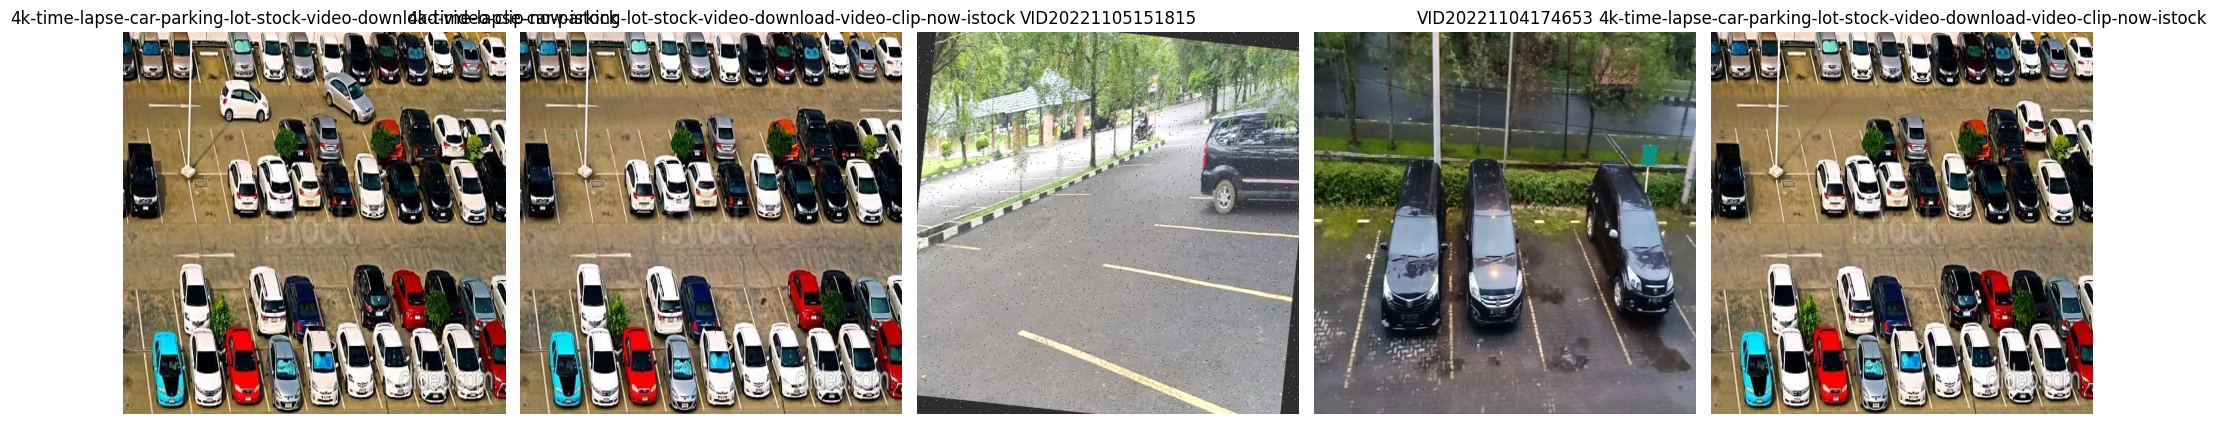

In [7]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Lokasi dataset
dataset_path = '/content/data/train/images'

# Ambil 5 gambar random
num_examples = 5
random_images = random.sample(os.listdir(dataset_path), num_examples)

# Buat plot
fig, axs = plt.subplots(1, num_examples, figsize=(20, 5))

for i, img_name in enumerate(random_images):

  # Buka gambar
  img_path = os.path.join(dataset_path, img_name)
  img = Image.open(img_path)

  # Dapatkan label dari nama file
  label = img_name.split('_')[0]

  # Tampilkan gambar dan label
  axs[i].set_title(label)
  axs[i].imshow(img)
  axs[i].axis(False)

plt.tight_layout()

## Create config.yaml


In [8]:
%%writefile data/config.yaml
train: /content/data/train/images
val: /content/data/valid/images
test: /content/data/test/images

nc: 2
names: ['empty', 'occupied']

Writing data/config.yaml


## Create Custom Network Architecture

In [9]:
%%writefile data/yolov8.yaml
# Ultralytics YOLO 🚀, AGPL-3.0 license
# YOLOv8 object detection model with P3-P5 outputs. For Usage examples see https://docs.ultralytics.com/tasks/detect

# Parameters
nc: 6  # number of classes
scales: # model compound scaling constants, i.e. 'model=yolov8n.yaml' will call yolov8.yaml with scale 'n'
  # [depth, width, max_channels]
  n: [0.33, 0.25, 1024]  # YOLOv8n summary: 225 layers,  3157200 parameters,  3157184 gradients,   8.9 GFLOPs
  s: [0.33, 0.50, 1024]  # YOLOv8s summary: 225 layers, 11166560 parameters, 11166544 gradients,  28.8 GFLOPs
  m: [0.67, 0.75, 768]   # YOLOv8m summary: 295 layers, 25902640 parameters, 25902624 gradients,  79.3 GFLOPs
  l: [1.00, 1.00, 512]   # YOLOv8l summary: 365 layers, 43691520 parameters, 43691504 gradients, 165.7 GFLOPs
  x: [1.00, 1.25, 512]   # YOLOv8x summary: 365 layers, 68229648 parameters, 68229632 gradients, 258.5 GFLOPs

# YOLOv8.0n backbone
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [64, 3, 2]]  # 0-P1/2
  - [-1, 1, Conv, [128, 3, 2]]  # 1-P2/4
  - [-1, 3, C2f, [128, True]]
  - [-1, 1, Conv, [256, 3, 2]]  # 3-P3/8
  - [-1, 6, C2f, [256, True]]
  - [-1, 1, Conv, [512, 3, 2]]  # 5-P4/16
  - [-1, 6, C2f, [512, True]]
  - [-1, 1, Conv, [1024, 3, 2]]  # 7-P5/32
  - [-1, 3, C2f, [1024, True]]
  - [-1, 1, SPPF, [1024, 5]]  # 9

# YOLOv8.0n head
head:
  - [-1, 3, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 6], 1, Concat, [1]]  # cat backbone P4
  - [-1, 5, C2f, [512]]  # 12

  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 4], 1, Concat, [1]]  # cat backbone P3
  - [-1, 3, C2f, [256]]  # 15 (P3/8-small)

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 12], 1, Concat, [1]]  # cat head P4
  - [-1, 3, C2f, [512]]  # 18 (P4/16-medium)

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 9], 1, Concat, [1]]  # cat head P5
  - [-1, 3, C2f, [1024]]  # 21 (P5/32-large)

  - [[15, 18, 21], 1, Detect, [nc]]  # Detect(P3, P4, P5)

Writing data/yolov8.yaml


In [11]:
import torch
from ultralytics import YOLO

# Tentukan jalur menuju berkas konfigurasi YOLO yang sudah dimodifikasi
yolo_config_path = '/content/data/yolov8.yaml'

# Tentukan jalur menuju berkas bobot model pra-dilatih
pre_trained_model_path = '/content/yolov8n.pt'

# Buat model YOLO menggunakan konfigurasi yang sudah dimodifikasi
model = YOLO(yolo_config_path)

# Muat bobot model pra-dilatih ke model baru
model.load(pre_trained_model_path)

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 318/367 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

# Train

In [12]:
!yolo detect train data=/content/data/config.yaml model=/content/data/yolov8.yaml \
  pretrained=yolov8n.pt \
  epochs=10 \
  imgsz=640 \
  device=0 \
  name=test_projek_akhir \
  workers=24 \
  lr0=0.0003 \
  lrf=0.0028 \
  momentum=0.73375 \
  weight_decay=0.00015 \
  warmup_epochs=1.22935 \
  warmup_momentum=0.1525 \
  box=17 \
  cls=1.32899 \
  dfl=0.56016 \
  optimizer=Adam

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 318/367 items from pretrained weights
Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/data/yolov8.yaml, data=/content/data/config.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=24, project=None, name=test_projek_akhir, exist_ok=False, pretrained=yolov8n.pt, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, emb

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the paths to the result files
confusion_matrix_path = '/content/runs/detect/test_projek_akhir/confusion_matrix.png'
F1_curve_path = '/content/runs/detect/test_projek_akhir/F1_curve.png'
PR_curve_path = '/content/runs/detect/test_projek_akhir/PR_curve.png'
P_curve_path = '/content/runs/detect/test_projek_akhir/P_curve.png'
R_curve_path = '/content/runs/detect/test_projek_akhir/R_curve.png'
results_path = '/content/runs/detect/test_projek_akhir/results.png'

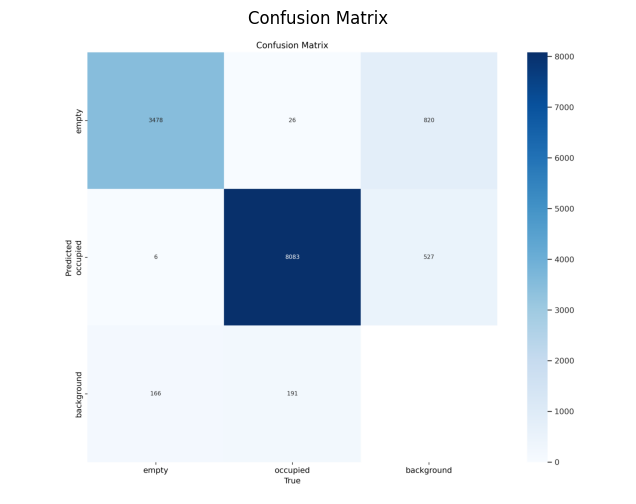

In [14]:
# Display the confusion matrix
confusion_matrix = mpimg.imread(confusion_matrix_path)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix)
plt.title('Confusion Matrix')
plt.axis('off')
plt.show()

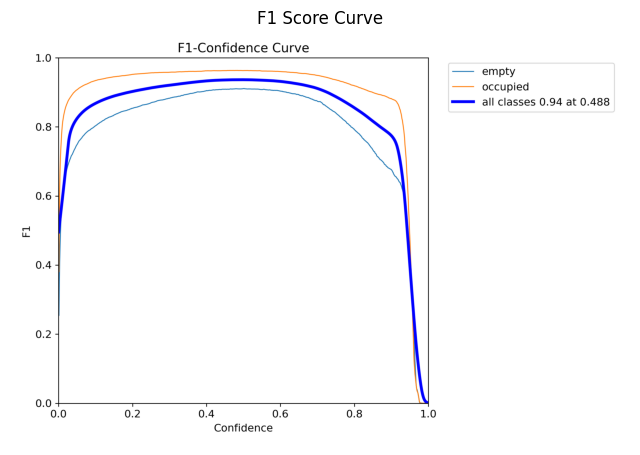

In [15]:
# Display F1 Score Curve
F1_curve = mpimg.imread(F1_curve_path)
plt.figure(figsize=(8, 6))
plt.imshow(F1_curve)
plt.title('F1 Score Curve')
plt.axis('off')
plt.show()

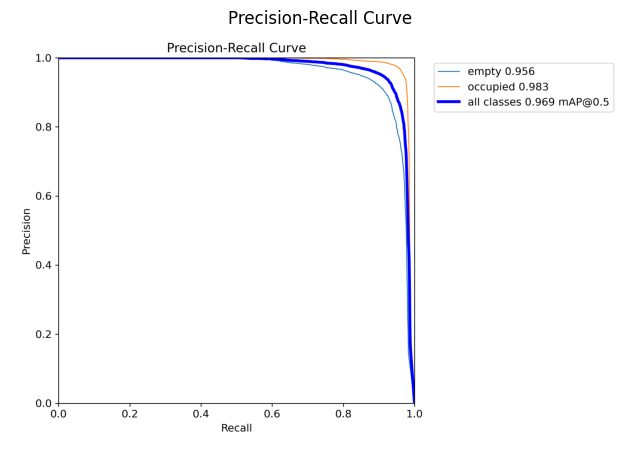

In [16]:
# Display Precision-Recall Curve
PR_curve = mpimg.imread(PR_curve_path)
plt.figure(figsize=(8, 6))
plt.imshow(PR_curve)
plt.title('Precision-Recall Curve')
plt.axis('off')
plt.show()

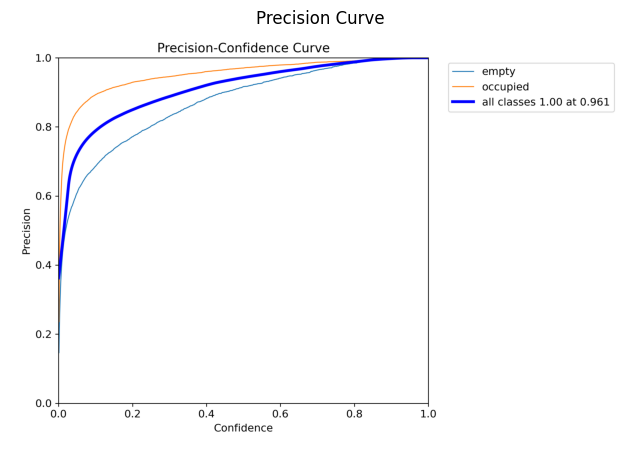

In [17]:
# Display Precision Curve
P_curve = mpimg.imread(P_curve_path)
plt.figure(figsize=(8, 6))
plt.imshow(P_curve)
plt.title('Precision Curve')
plt.axis('off')
plt.show()

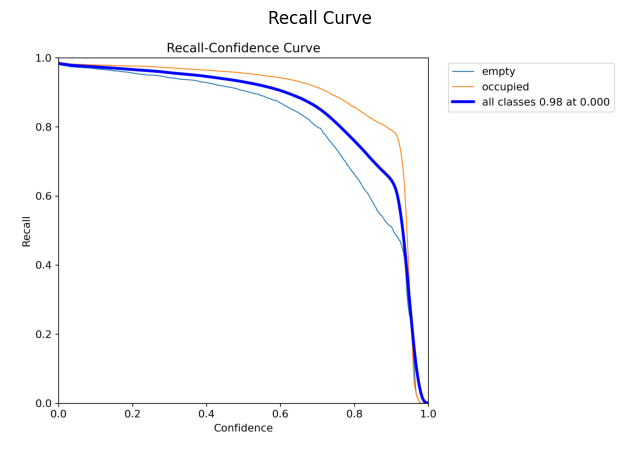

In [18]:
# Display Recall Curve
R_curve = mpimg.imread(R_curve_path)
plt.figure(figsize=(8, 6))
plt.imshow(R_curve)
plt.title('Recall Curve')
plt.axis('off')
plt.show()

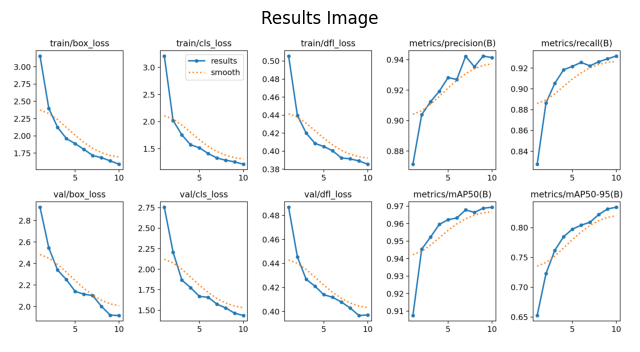

In [19]:
# Display Results Image
results_image = mpimg.imread(results_path)
plt.figure(figsize=(8, 6))
plt.imshow(results_image)
plt.title('Results Image')
plt.axis('off')
plt.show()

# Validation

In [20]:
!yolo detect val model=/content/runs/detect/test_projek_akhir/weights/best.pt data=data/config.yaml

Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8 summary (fused): 173 layers, 3,088,086 parameters, 0 gradients, 8.3 GFLOPs
val: Scanning /content/data/valid/labels.cache... 558 images, 29 backgrounds, 0 corrupt: 100% 558/558 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8307, len(boxes) = 11950. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 35/35 [00:09<00:00,  3.76it/s]
                   all        558      11950      0.941      0.932      0.969      0.834
                 empty        503       3650      0.913      0.907      0.956      0.784
              occupied        484       8300       0.97      0.957      0.983      0.884
Speed: 1.4ms preprocess, 4.1ms inference, 0.0ms l

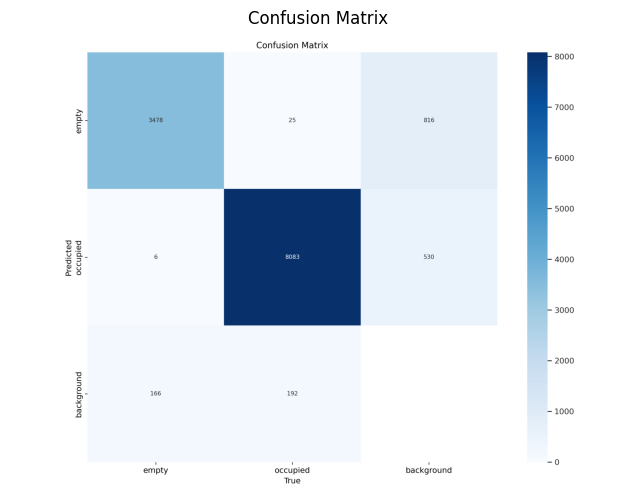

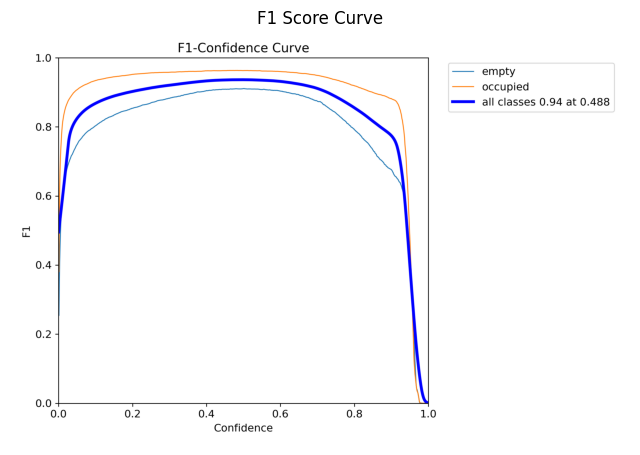

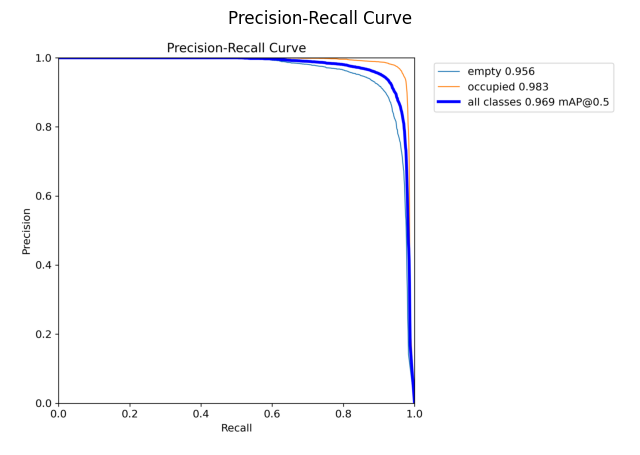

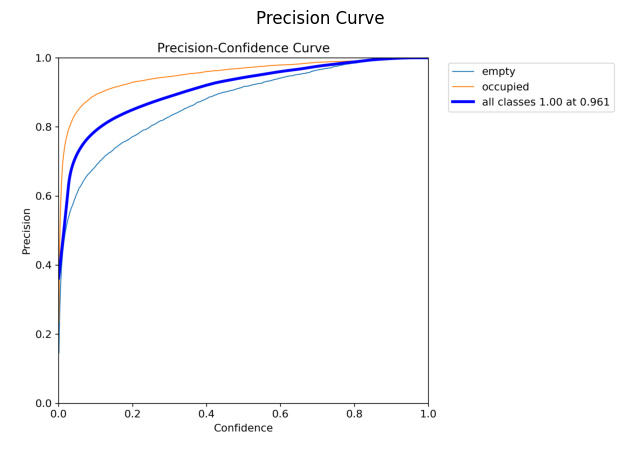

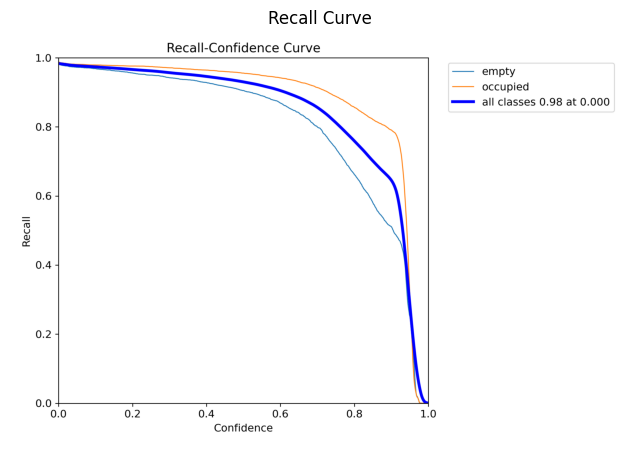

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the paths to the result files
confusion_matrix_path = '/content/runs/detect/val/confusion_matrix.png'
f1_curve_path = '/content/runs/detect/val/F1_curve.png'
PR_curve_path = '/content/runs/detect/val/PR_curve.png'
P_curve_path = '/content/runs/detect/val/P_curve.png'
R_curve_path = '/content/runs/detect/val/R_curve.png'

# Display the confusion matrix
confusion_matrix = mpimg.imread(confusion_matrix_path)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix)
plt.title('Confusion Matrix')
plt.axis('off')
plt.show()

# Display F1 Score Curve
F1_curve = mpimg.imread(F1_curve_path)
plt.figure(figsize=(8, 6))
plt.imshow(F1_curve)
plt.title('F1 Score Curve')
plt.axis('off')
plt.show()

# Display Precision-Recall Curve
PR_curve = mpimg.imread(PR_curve_path)
plt.figure(figsize=(8, 6))
plt.imshow(PR_curve)
plt.title('Precision-Recall Curve')
plt.axis('off')
plt.show()

# Display Precision Curve
P_curve = mpimg.imread(P_curve_path)
plt.figure(figsize=(8, 6))
plt.imshow(P_curve)
plt.title('Precision Curve')
plt.axis('off')
plt.show()

# Display Recall Curve
R_curve = mpimg.imread(R_curve_path)
plt.figure(figsize=(8, 6))
plt.imshow(R_curve)
plt.title('Recall Curve')
plt.axis('off')
plt.show()

# Test

In [24]:
!yolo detect predict model=/content/runs/detect/test_projek_akhir/weights/best.pt source='/content/data/test/images'

Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8 summary (fused): 173 layers, 3,088,086 parameters, 0 gradients, 8.3 GFLOPs

image 1/226 /content/data/test/images/00000301_jpg.rf.29c98c74a995211b2d5c8b879129ff88.jpg: 640x640 6 occupieds, 12.8ms
image 2/226 /content/data/test/images/002_20220315_174541-mp4_20220318_114126-099_jpg.rf.f0c9d0ced59a4436a5e9eecefd5b8e5c.jpg: 640x640 3 emptys, 1 occupied, 11.1ms
image 3/226 /content/data/test/images/005_20220315_175214-mp4_20220319_124945-433_jpg.rf.3ab354be4dd39acde531da92d4baad34.jpg: 640x640 4 occupieds, 10.6ms
image 4/226 /content/data/test/images/005_20220315_175214-mp4_20220319_124947-433_jpg.rf.4e0aa6c9b87adf027b05271215186fce.jpg: 640x640 1 empty, 3 occupieds, 10.6ms
image 5/226 /content/data/test/images/010_20220316_181755-mp4_20220319_125732-059_jpg.rf.6a5f0d53cf9553dc0dc35534ef759f11.jpg: 640x640 4 emptys, 2 occupieds, 11.3ms
image 6/226 /content/data/test/images/1-Copy-Copy_jpg.rf.4b1ef5033f

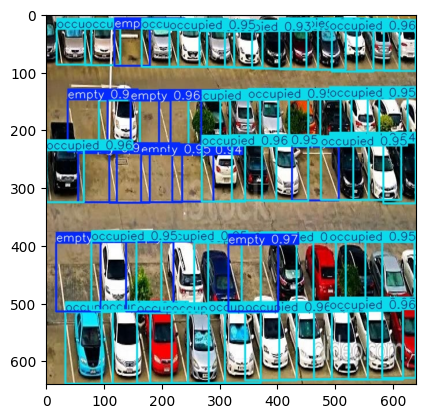

In [26]:
detections_dir = "/content/runs/detect/predict"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))